In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
% matplotlib inline
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor

In [2]:
## Data Source: https://www.kaggle.com/manjeetsingh/retaildataset
# read the ['Features data set.csv', 'sales data-set.csv', 'stores data-set.csv'] from the /data folder
import os
print("current directory is : " + os.getcwd()) 
print('the /data folder contains:') 
print(os.listdir("./data"))

stores = pd.read_csv('./data/stores data-set.csv')
features = pd.read_csv('./data/Features data set.csv')
sales = pd.read_csv('./data/sales data-set.csv')

## I don't intend to use so instead of replacing na-s with 0 I better drop them all
markdown_cols = features.filter(like='MarkDown').columns
for column in markdown_cols:
     features = features.drop(column,axis=1)

# On features Fill na gaps forward on CPI and Unemployment, Data seems sorted by date already
# https://pandas.pydata.org/pandas-docs/stable/user_guide/missing_data.html
features['CPI'] = features['CPI'].fillna(method='pad')
features['Unemployment'] = features['Unemployment'].fillna(method='pad')

current directory is : C:\Users\User\projects\retail_kaggle
the /data folder contains:
['Features data set.csv', 'sales data-set.csv', 'stores data-set.csv']


In [3]:
# merge left all tables, use only keys from left frame, similar to a SQL left outer join; preserve key order.
    
retail = pd.merge(sales, features, how = 'left', on = ['Store', 'Date', 'IsHoliday'])
retail = pd.merge(retail, stores, how = 'left', on = ['Store'])

# format date in datetime, we need it to extract Year and Year week later to split the data in train, test
retail['Date'] = pd.to_datetime(retail['Date'])
retail['Year'] = pd.DatetimeIndex(retail['Date']).year
retail['Month'] = pd.DatetimeIndex(retail['Date']).month

retail['Year-Week'] = retail['Date'].dt.strftime('%Y-%U')

# I noticed there are Sales figures that are negative, cleanup:
retail = retail[retail['Weekly_Sales']>=0]

# turn IsHoliday into an Integer, useful later for numeric computations
retail['IsHoliday'] = retail['IsHoliday'].astype(int)

# Sort by Date as the data is not ordered by Date
retail = retail.sort_values(by=['Date'])

# checkout the dataset we're going to use further
retail.describe()

,Store,Dept,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,CPI,Unemployment,Size,Year,Month
count,420285.000000,420285.000000,420285.000000,420285.00000,420285.000000,420285.000000,420285.000000,420285.000000,420285.000000,420285.000000,420285.000000
mean,22.195477,44.242771,16030.329773,0.07034,60.090474,3.360888,171.212152,7.960077,136749.569176,2010.968443,6.478501
std,12.787213,30.507197,22728.500149,0.25572,18.448260,0.458523,39.162280,1.863873,60992.688568,0.796893,3.324688
min,1.000000,1.000000,0.000000,0.00000,-2.060000,2.472000,126.064000,3.879000,34875.000000,2010.000000,1.000000
25%,11.000000,18.000000,2117.560000,0.00000,46.680000,2.933000,132.022667,6.891000,93638.000000,2010.000000,4.000000
50%,22.000000,37.000000,7659.090000,0.00000,62.090000,3.452000,182.350989,7.866000,140167.000000,2011.000000,6.000000
75%,33.000000,74.000000,20268.380000,0.00000,74.280000,3.738000,212.445487,8.567000,202505.000000,2012.000000,9.000000
max,45.000000,99.000000,693099.360000,1.00000,100.140000,4.468000,227.232807,14.313000,219622.000000,2012.000000,12.000000


In [4]:

# X_col = ['Temperature','Fuel_Price','CPI','Unemployment','Size', 'IsHoliday']

X_col = ['Unemployment']
y_col = ['Weekly_Sales']
X = retail[X_col].values
y = retail[y_col].values

In [5]:
tree = DecisionTreeRegressor(max_depth=3)
tree.fit(X, y)

DecisionTreeRegressor(criterion='mse', max_depth=3, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [6]:
sort_idx = X.flatten().argsort()

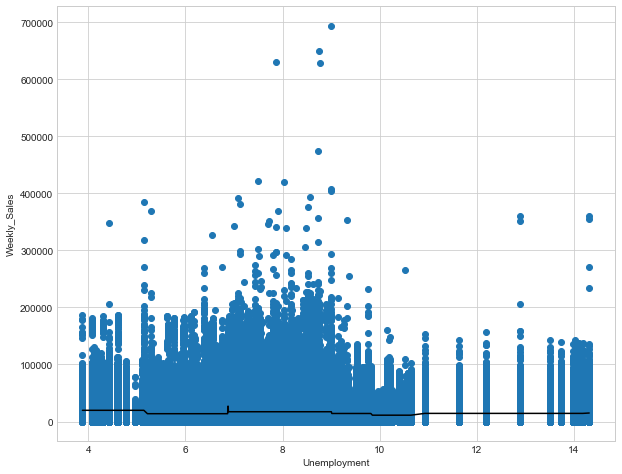

In [7]:
plt.figure(figsize=(10,8))
plt.scatter(X[sort_idx], y[sort_idx])
plt.plot(X[sort_idx], tree.predict(X[sort_idx]), color='k')

plt.xlabel('Unemployment')
plt.ylabel('Weekly_Sales');

In [8]:
X_col = ['Temperature','Fuel_Price','CPI','Unemployment','Size', 'IsHoliday']
y_col = ['Weekly_Sales']
X = retail[X_col].values
y = retail[y_col].values
# Split the data in train test using sklearn 
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=0)



In [9]:
tree = DecisionTreeRegressor(max_depth=3)
tree.fit(X, y)

DecisionTreeRegressor(criterion='mse', max_depth=3, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [10]:
y_train_pred = tree.predict(X_train)

In [13]:
y_test_pred = tree.predict(X_test)
print("MSE train: {0:.4f}, test: {1:.4f}".\
      format(mean_squared_error(y_train, y_train_pred), 
             mean_squared_error(y_test, y_test_pred)))

MSE train: 483029701.7167, test: 471842998.9356


In [14]:
print("R^2 train: {0:.4f}, test: {1:.4f}".\
      format(r2_score(y_train, y_train_pred),
             r2_score(y_test, y_test_pred)))

R^2 train: 0.0688, test: 0.0712


In [15]:
#Random Forrests
X_col = ['Temperature','Fuel_Price','CPI','Unemployment','Size', 'IsHoliday']
y_col = ['Weekly_Sales']
X = retail[X_col]
y = retail[y_col]

# Split the data in train test using sklearn 
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=0)

In [16]:
from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(n_estimators=500, criterion='mse', 
                               random_state=42, n_jobs=-1)

In [17]:
forest.fit(X_train, y_train)

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [18]:
y_train_pred = forest.predict(X_train)

In [19]:
y_test_pred = forest.predict(X_test)
print("MSE train: {0:.4f}, test: {1:.4f}".\
      format(mean_squared_error(y_train, y_train_pred), 
             mean_squared_error(y_test, y_test_pred)))

MSE train: 462896876.7561, test: 471042398.9919


In [20]:
print("R^2 train: {0:.4f}, test: {1:.4f}".\
      format(r2_score(y_train, y_train_pred),
             r2_score(y_test, y_test_pred)))

R^2 train: 0.1076, test: 0.0728


In [21]:
# Brief Introduction to AdaBoost
from sklearn.ensemble import AdaBoostRegressor
ada = AdaBoostRegressor(DecisionTreeRegressor(max_depth=4), 
                        n_estimators=500, random_state=42)
ada.fit(X_train, y_train)


C:\Users\User\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


AdaBoostRegressor(base_estimator=DecisionTreeRegressor(criterion='mse', max_depth=4, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best'),
         learning_rate=1.0, loss='linear', n_estimators=500,
         random_state=42)

In [22]:
y_train_pred = ada.predict(X_train)
y_test_pred = ada.predict(X_test)
print("MSE train: {0:.4f}, test: {1:.4f}".\
      format(mean_squared_error(y_train, y_train_pred), 
             mean_squared_error(y_test, y_test_pred)))

MSE train: 548418472.8570, test: 542965999.2979


In [23]:
print("R^2 train: {0:.4f}, test: {1:.4f}".\
      format(r2_score(y_train, y_train_pred),
             r2_score(y_test, y_test_pred)))

R^2 train: -0.0572, test: -0.0688


In [ ]:
## Features Importance according to AdaBoost

In [25]:
result = pd.DataFrame(ada.feature_importances_, X.columns)
result.columns = ['feature']
result.sort_values(by='feature', ascending = False)

,feature
Size,0.446171
IsHoliday,0.195197
Unemployment,0.189371
Temperature,0.080419
CPI,0.071320
Fuel_Price,0.017522


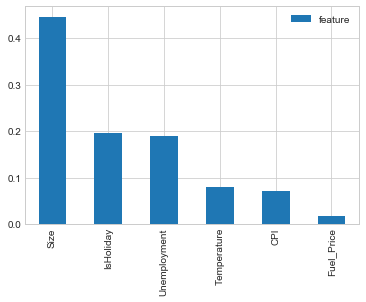

In [26]:
result.sort_values(by='feature', ascending = False).plot(kind='bar')

In [ ]:
## Features Importance according to Random Forrests

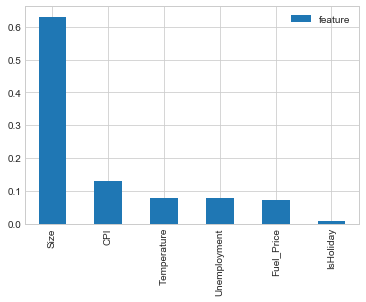

In [27]:
forest.feature_importances_
result = pd.DataFrame(forest.feature_importances_,X.columns)
result.columns = ['feature']
result.sort_values(by='feature', ascending=False).plot(kind='bar')

In [ ]:
## Features Importance according to Decision Trees

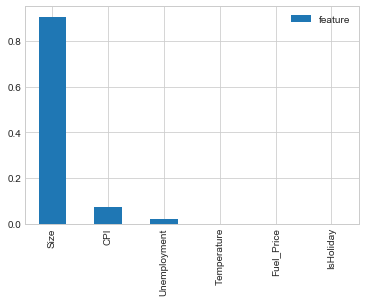

In [28]:
tree.feature_importances_
result = pd.DataFrame(tree.feature_importances_,X.columns)
result.columns = ['feature']
result.sort_values(by='feature', ascending=False).plot(kind='bar')